Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1, 100)            52400     
                                                                 
 lstm_43 (LSTM)              (None, 1, 100)            80400     
                                                                 
 lstm_44 (LSTM)              (None, 50)                30200     
                                                                 
 dense_28 (Dense)            (None, 8)                 408       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 163417 (638.35 KB)
Trainable params: 16

19/19 [==============================] - 0s 23ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 42/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 43/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 44/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 45/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0101 - root_mean_squared_error: 0.1007 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 46/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0043 - val_root_me

19/19 [==============================] - 0s 23ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 89/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 90/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 91/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 92/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 93/100
19/19 [==============================] - 0s 23ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0036 - val_root_me

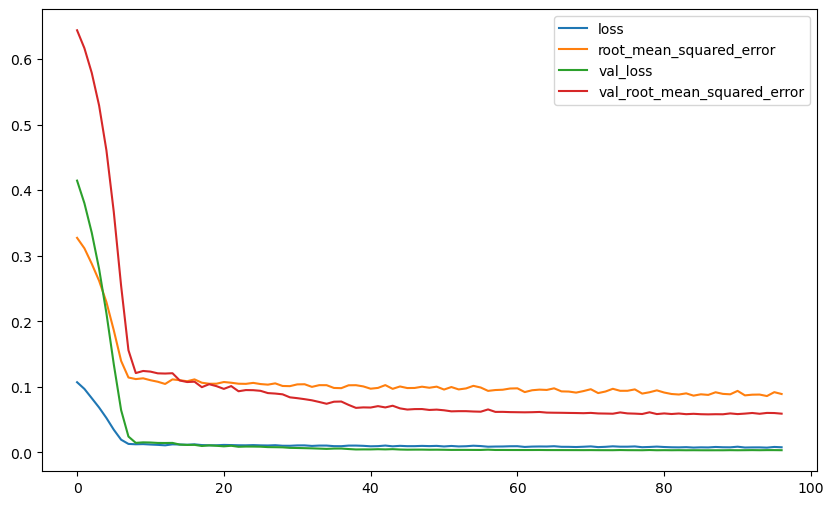

In [59]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from statsmodels.nonparametric.smoothers_lowess import lowess

#epochs 학습횟수
set_epochs = 100
#loess조절
frac_rate = 0.00

#데이터셋 로드
temp_csv_path = 'monthly_temp.csv'
df = pd.read_csv(temp_csv_path)

#데이터셋 시간 형식 지정
df['Date'] = pd.to_datetime(df['Date'])
#GCAG데이터 사용
df = df[~df['Source'].str.contains('GISTEMP')]
#필요없는 열 삭제
df.drop(['Source'], axis=1, inplace=True)

#LOEWSS 변환
y = df['Mean'].dropna()
x = np.arange(0,len(y))
res = lowess(endog=y,exog=x,frac=frac_rate,it=3)
df['lowess_temp'] = res[:,1]
df.drop(['Mean'], axis=1, inplace=True)

#정렬 순서
df = df[::-1]
#인덱스 리셋
df = df.reset_index(drop=True)

data = df['lowess_temp'].values
data = data.reshape((-1,1))

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# Split into training/test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size,], data[train_size:,]

# Prepare the data in a format required for LSTM (samples, timesteps, features)
def Create_Dataset(df, lookback=1):
    X, Y = [], []
    for i in range(len(df) - lookback - 1):
        X.append(df[i:(i+lookback), 0])
        Y.append(df[i + lookback,0])
    return np.array(X), np.array(Y)

lookback = 30
X_train, Y_train = Create_Dataset(train, lookback)
X_test, Y_test   = Create_Dataset(test, lookback)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

#feature의 갯수
n_features = 1                        
#Sequential모델사용
model1 = Sequential()
#레이어 구조 설정
model1.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation = 'linear'))
#레이어 구조 출력
model1.summary()
#과도학습 방지
early_stop = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 2)
#학습
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.0001), 
               metrics = RootMeanSquaredError())

history = model1.fit(X_train, Y_train, 
                    epochs=set_epochs, 
                    batch_size=70,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

#학습 history 그래프로 출력
losses_df1 = pd.DataFrame(model1.history.history)
losses_df1.plot(figsize = (10,6))

# 모델 저장
model1.save('LSTM_Models/lstm_univariate.keras')
# 모델 로드
model1 = load_model('LSTM_Models/lstm_univariate.keras')

10/10 [==============================] - 0s 3ms/step


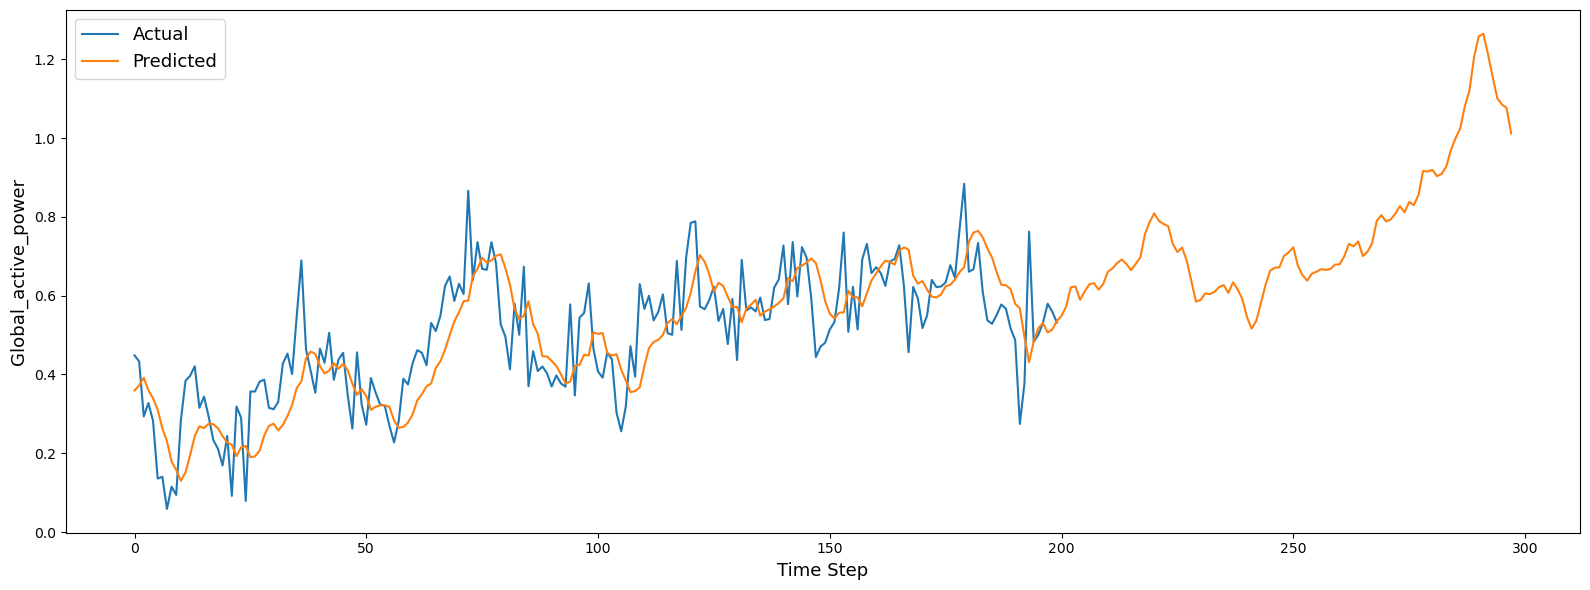

In [60]:
# Make the predictions
train_predict = model1.predict(X_train)
test_predict  = model1.predict(X_test)

# Invert the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict  = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

actual = Y_test[0][:200]
predicted = test_predict[:,0][:300]

plt.figure(figsize=(16,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.ylabel('temp', size=13)
plt.xlabel('Time Step', size=13)
plt.tight_layout()
plt.legend(fontsize=13)
plt.show()